# Introduction

With the developments of hardware devices capable of handling large amount computation in the recent years, deep learning has seen remarkable surge in capabilities and applications. Deep learning has yielded substantial number of state-of-the-art machine learning models for a variety of tasks which were previously deemed possible only with human intervention. Among the most intriguing applications of deep learning is its potential in creative writing and arts, where it has demonstrated its ability to augment human creativity with vast processing power and pattern recognition capabilities. The application of deep learning is particularly noteworthy in natural language processing (NLP), where newer models have demonstrated abilities to understand the underlying context in text and almost being able to mimic human conscience, as we have seen with ChatGPT.

This project aims to explore similar application of deep learning by utilizing a transformer-based model, particularly GPT2, to generate text in the style of Sherlock Holmes stories by Sir Arthur Conan Doyle. The iconic detective series, known for its intricate plots and the dynamic between its main characters, Sherlock Holmes and Dr. John Watson, presents a rich canvas for examining the ability of deep learning models to capture and replicate human literary creativity.

## Objectives

- To demonstrate the application of deep learning in creative writing by mimicing Sir Arthur Conan Doyle's style
- To gain hands on experience with fine-tuning and transfer learning for a large language model

## Dataset

The dataset for the project was obtained from [Kaggle](https://www.kaggle.com/datasets/muhammadbilalhaneef/sherlock-holmes-next-word-prediction-corpus). The corpus contained a text file with 12 Sherlock Homes stories in plain English.

# Exploratory Data Analysis

Since the dataset here is a pile of text, it might be best to break it down to individual stories to analyze the distribution of words and sentences within stories.

In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import nltk
from tqdm import tqdm
import torch

nltk.download('punkt')
nltk.download('stopwords')

file_path = '/kaggle/input/sherlock-holmes-next-word-prediction-corpus/Sherlock Holmes.txt'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [57]:
with open(file_path, 'r', encoding='utf-8') as file:
    text = file.read()

print(text[:300])





                        THE ADVENTURES OF SHERLOCK HOLMES

                               Arthur Conan Doyle



                                Table of contents

               A Scandal in Bohemia
               The Red-Headed League
               A Case of Identity
               The Boscomb


Upon a quick manual inspection of the corpus, it was observed that it contained twelve stories. For better analysis, it was important to convert the corpus to a group of stories that can be compared and contrasted in terms of words and sentences. This could also be useful to feed into the transformer based deep neural network as having stories separated into chunks gives the ability to add special start and end tokens.

In [3]:
story_titles = [t.lower() for t in [
    "A Scandal in Bohemia",
    "The Red-Headed League",
    "A Case of Identity",
    "The Boscombe Valley Mystery",
    "The Five Orange Pips",
    "The Man with the Twisted Lip",
    "The Adventure of the Blue Carbuncle",
    "The Adventure of the Speckled Band",
    "The Adventure of the Engineer's Thumb",
    "The Adventure of the Noble Bachelor",
    "The Adventure of the Beryl Coronet",
    "The Adventure of the Copper Beeches"
]]

# Split the text into stories
stories = {}
current_story = None
for line in text[730:].split('\n'):
    if line.strip().lower() in story_titles:
        current_story = line.strip().lower()

        stories[current_story] = ""
    elif current_story:
        stories[current_story] += line + '\n'


print(f"Total stories extracted: {len(stories)}")
first_title = list(stories.keys())[0]
print(f"First story: {first_title}, Content Preview: {stories[first_title][:1000]}")

Total stories extracted: 12
First story: a scandal in bohemia, Content Preview: 




                                Table of contents
                                     Chapter 1
                                     Chapter 2
                                     Chapter 3















          CHAPTER I



     To Sherlock Holmes she is always the woman. I have seldom heard him
     mention her under any other name. In his eyes she eclipses and
     predominates the whole of her sex. It was not that he felt any
     emotion akin to love for Irene Adler. All emotions, and that one
     particularly, were abhorrent to his cold, precise but admirably
     balanced mind. He was, I take it, the most perfect reasoning and
     observing machine that the world has seen, but as a lover he would
     have placed himself in a false position. He never spoke of the softer
     passions, save with a gibe and a sneer. They were admirable things
     for the observer--excellent for drawing the 

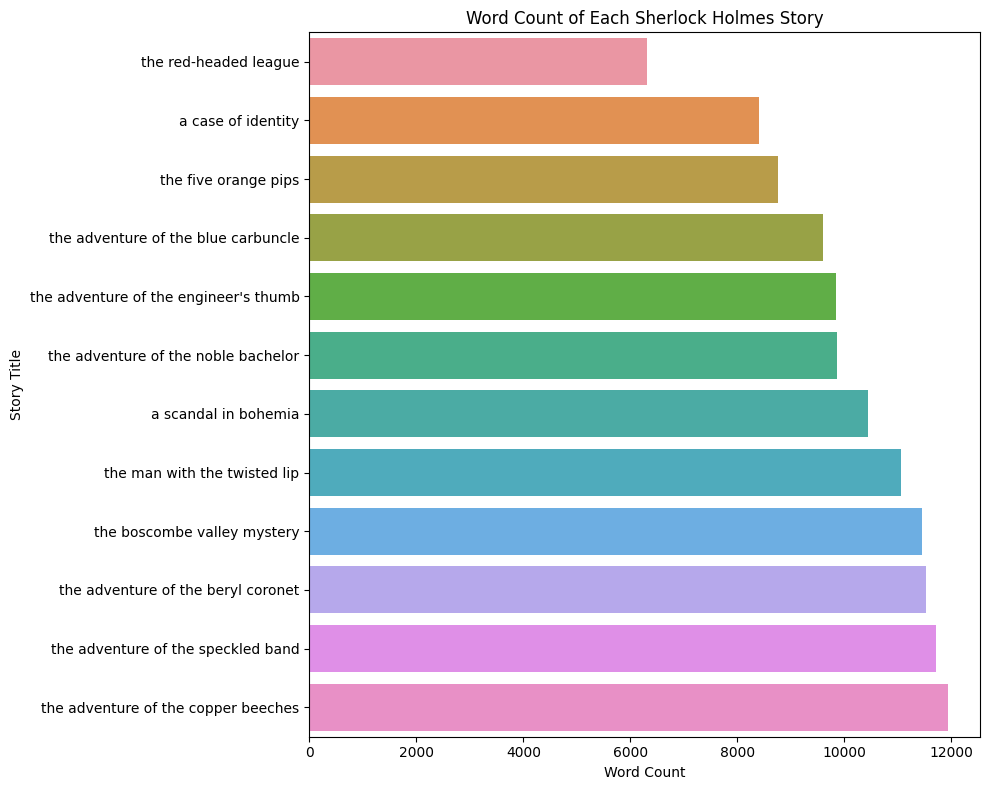

In [4]:
word_counts = {title: len(word_tokenize(text)) for title, text in stories.items()}

word_counts_df = pd.DataFrame(list(word_counts.items()), columns=['Story Title', 'Word Count'])

plt.figure(figsize=(10, 8))
sns.barplot(x='Word Count', y='Story Title', data=word_counts_df.sort_values('Word Count'))
plt.title('Word Count of Each Sherlock Holmes Story')
plt.xlabel('Word Count')
plt.ylabel('Story Title')
plt.tight_layout()

The stories varied in length - with __The Red-Headed League__ being the shortest with about 7000 words and __The Adventuire of the Copper Beeches__ being the longest with about 12000 words.

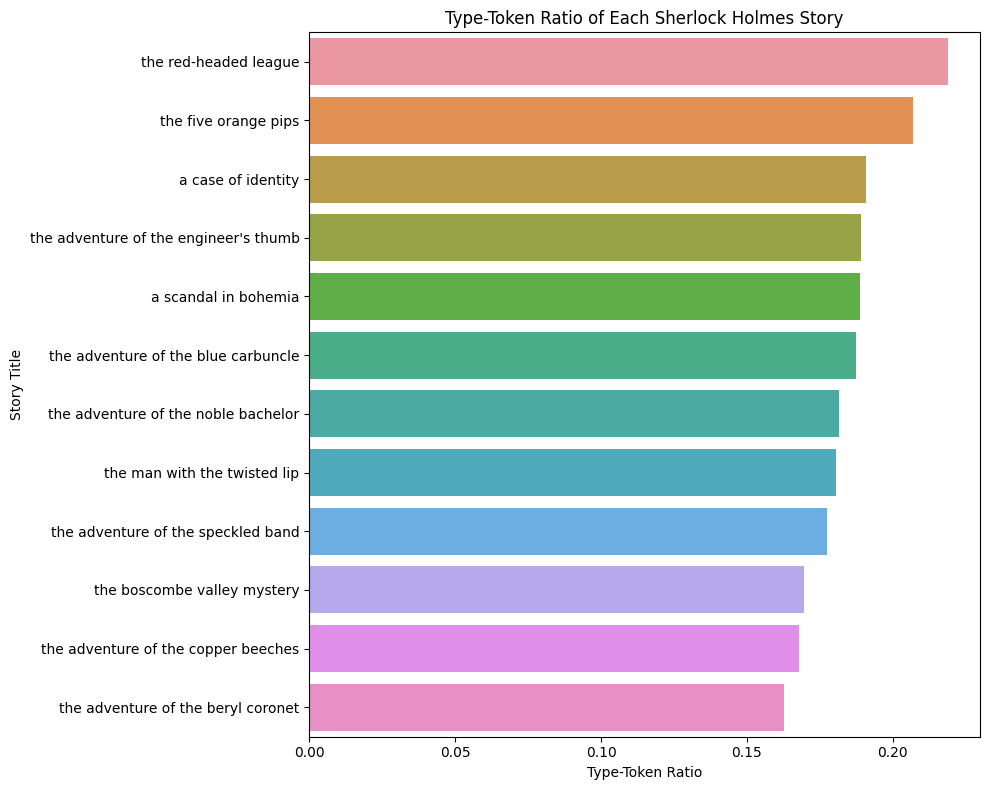

In [5]:
def calculate_ttr(text):
    tokens = word_tokenize(text.lower())
    types = set(tokens)
    return len(types) / len(tokens) if tokens else 0

ttr = {title: calculate_ttr(text) for title, text in stories.items()}

ttr_df = pd.DataFrame(list(ttr.items()), columns=['Story Title', 'Type-Token Ratio'])

plt.figure(figsize=(10, 8))
sns.barplot(x='Type-Token Ratio', y='Story Title', data=ttr_df.sort_values('Type-Token Ratio', ascending=False))
plt.title('Type-Token Ratio of Each Sherlock Holmes Story')
plt.xlabel('Type-Token Ratio')
plt.ylabel('Story Title')
plt.tight_layout()

From this visualization, we can see that some stories have a relatively higher TTR, indicating a more diverse vocabulary within those texts.

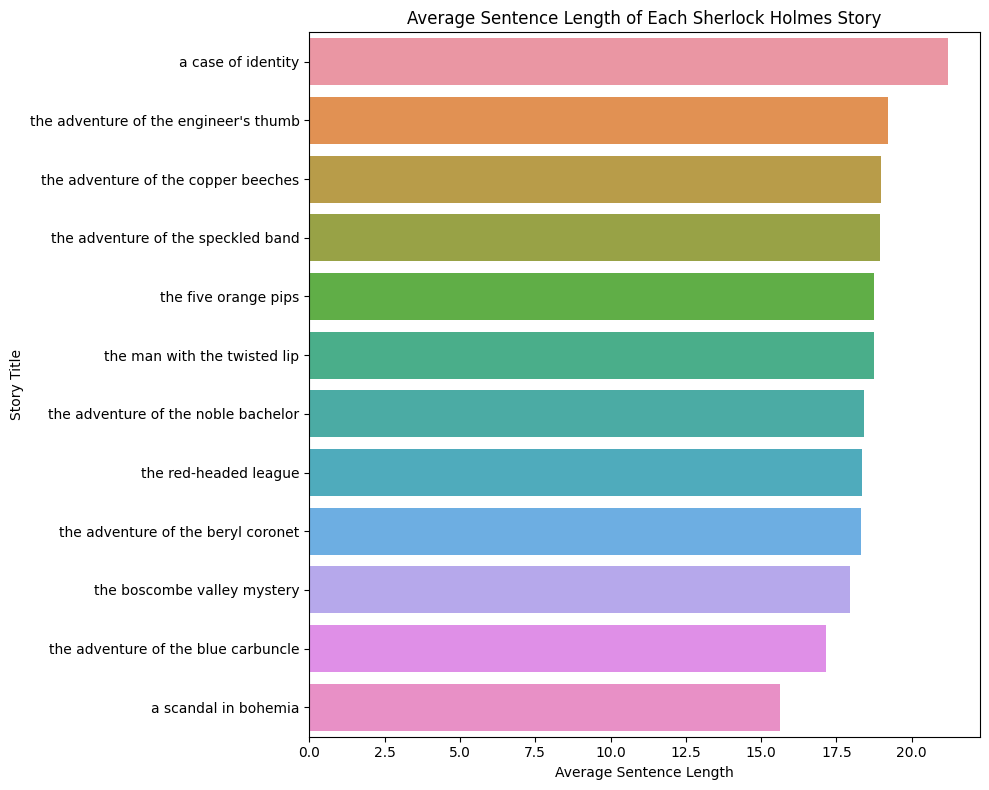

In [6]:
def calculate_avg_sentence_length(text):
    sentences = sent_tokenize(text)
    sentence_lengths = [len(word_tokenize(sentence)) for sentence in sentences]
    return sum(sentence_lengths) / len(sentence_lengths) if sentence_lengths else 0

avg_sentence_length = {title: calculate_avg_sentence_length(text) for title, text in stories.items()}

sentence_length_df = pd.DataFrame(list(avg_sentence_length.items()), columns=['Story Title', 'Average Sentence Length'])

plt.figure(figsize=(10, 8))
sns.barplot(x='Average Sentence Length', y='Story Title', data=sentence_length_df.sort_values('Average Sentence Length', ascending=False))
plt.title('Average Sentence Length of Each Sherlock Holmes Story')
plt.xlabel('Average Sentence Length')
plt.ylabel('Story Title')
plt.tight_layout()

Based on this, it appears like some stories tend to have longer average sentence lengths, which could suggest a more complex or descriptive narrative style, while others have shorter average lengths, which may imply a more straightforward or action-driven style.

## Data Cleaning and Preparation

The corpus was divided to separate stories to feed into the network (which was done a few cells earlier, before the visualizations). Further, to be fed into a GPT2 based model for transfer learning (or fine tuning in this case), the stories need to be tokenized. 

Tokenization is a fundamental process in natural language processing (NLP) that involves breaking down text into smaller units, such as words or subwords, which the model can understand and process. For the GPT-2 model, which has been pre-trained on a vast corpus of text data, tokenization also involves mapping each word or subword in our dataset to an index in GPT-2's predefined vocabulary.

In [7]:
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

tokenized_stories = []
for story in stories.values():
    # Encode the stories and add the special tokens
    tokenized_story = tokenizer.encode(story, add_special_tokens=True, max_length=1024, truncation=True)
    tokenized_stories.append(tokenized_story)

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [8]:
from torch.utils.data import Dataset, DataLoader

class SherlockDataset(Dataset):
    def __init__(self, tokenized_stories):
        self.tokenized_stories = tokenized_stories
    
    def __len__(self):
        return len(self.tokenized_stories)
    
    def __getitem__(self, idx):
        return torch.tensor(self.tokenized_stories[idx])

dataset = SherlockDataset(tokenized_stories)
loader = DataLoader(dataset, batch_size=2, shuffle=True)

Now that the dataset is ready to be fed into the model, the next step will be to build the model that can predict new Sherlock Holmes stories.

# Model Building

Given the project's focus on text generation, it was decided to fine-tune GPT-2's weights to generate Sherlock Holmes style stories. This decision was made particularly because of the limited size of the corpus plus training large language models are very resource intensive. GPT-2's pre-trained model serves as an excellent starting point, having been trained on a diverse range of internet text. 

In [9]:
from transformers import GPT2LMHeadModel, AdamW
from torch.utils.data import random_split

model = GPT2LMHeadModel.from_pretrained('gpt2')

optimizer = AdamW(model.parameters(), lr=5e-5)

model.to(device)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 2

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [10]:
epochs = 100 

model.train()
for epoch in (pbar:=tqdm(range(epochs))):
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        inputs = batch.to(device)
        labels = batch.to(device)
        outputs = model(inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    pbar.set_description(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")

Epoch 100, Loss: 0.04220145419239998: 100%|██████████| 100/100 [05:48<00:00,  3.49s/it]


In [22]:
def generate_text(model, prompt, length=100):
    encoded_input = tokenizer.encode(prompt, return_tensors='pt')
    encoded_input = encoded_input.to(device)
    output_sequences = model.generate(
        input_ids=encoded_input,
        max_length=length + len(encoded_input[0]),
        temperature=1.0,
        top_k=50,
        top_p=0.95,
        repetition_penalty=1.2,
        do_sample=True,
        num_return_sequences=1
    )

    return tokenizer.decode(output_sequences[0], skip_special_tokens=True)

prompt = "Sherlock Holmes"
generated_text = generate_text(model, prompt, length=500)
print(generated_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sherlock Holmes was once a woman, and she could be found in her new room. "And what of me? I know."


The Doctor seemed to believe he had made some acquaintance with him as an old-fashioned gentleman for his own pleasure during the war when Sherlock sat down at breakfast every morning wondering how much more should have been put into any man's pocket than that which they themselves were making so long; but this moment certainly did not seem worth mentioning them if it came from one half dozen years before yesterday or another just about day after we began our inquiry on their relations upon us all night ago—for only five months longer by today--and then finally twenty twelve days later there followed two accounts under such high coverages: those who knew Mr John Smith very well indeed (the story is true) being known both himself here[Pg 24] whereto reside, amongst other persons having come together perhaps thirty times past midnight above seven o'clock,—both between whom each told noth

It did generate some text, but very random. It is observed that the text does include some items from the actual detective series, but appears like the model needs further tuning to be able to generate more coherent stories.

## Hyperparameters Tuning

The only hyperparameter that could produce meaningful change here in case of the model was the learning rate. Several learning rates were tested for a few epochs to find the average loss to determine the best learning rate for the model. 

In [21]:
from transformers import get_linear_schedule_with_warmup

epochs = 4  
num_training_steps = epochs * len(train_loader)

learning_rates = [5e-3, 5e-4, 1e-4, 9e-5, 8e-5, 6e-5, 5e-5, 3e-5, 2e-5]

results = []

def train_and_generate(model, optimizer, scheduler, lr):
    model.train()
    total_loss = 0
    for epoch in range(epochs):
        for batch in train_loader:
            optimizer.zero_grad()
            inputs = batch.to(device)
            labels = batch.to(device)
            outputs = model(inputs, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
    avg_loss = total_loss / (len(train_loader) * epochs)
    print(f"Training complete | Avg Loss: {avg_loss}")
    results.append({
        'lr': lr,
        'avg_loss': avg_loss,
    })

for lr in learning_rates:
    model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)
    optimizer = AdamW(model.parameters(), lr=lr)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

    print(f"Training with lr: {lr}")
    train_and_generate(model, optimizer, scheduler, lr)

best_hyperparameters = min(results, key=lambda x:x['avg_loss'])
print(f"Best Learning Rate: {best_hyperparameters}")


Training with lr: 0.005
Training complete | Avg Loss: 6.234154665470124
Training with lr: 0.0005
Training complete | Avg Loss: 3.3244523763656617
Training with lr: 0.0001
Training complete | Avg Loss: 2.7676230907440185
Training with lr: 9e-05
Training complete | Avg Loss: 2.7845319628715517
Training with lr: 8e-05
Training complete | Avg Loss: 2.767478609085083
Training with lr: 6e-05
Training complete | Avg Loss: 2.7943820714950562
Training with lr: 5e-05
Training complete | Avg Loss: 2.8220039129257204
Training with lr: 3e-05
Training complete | Avg Loss: 2.8935954570770264
Training with lr: 2e-05
Training complete | Avg Loss: 2.940003144741058
Best Learning Rate: {'lr': 8e-05, 'avg_loss': 2.767478609085083}


## Fine-tuned Model

Based on the result of the hyperparameter search, a learning rate of 0.00008 was determined to produce the least loss over four epochs of testing. Using this value, let's train a new model.

In [39]:
new_model = GPT2LMHeadModel.from_pretrained('gpt2')
new_model.to(device)
optimizer = AdamW(new_model.parameters(), lr=8e-5)
epochs = 100 

new_model.train()
epoch_losses = []
for epoch in (pbar:=tqdm(range(epochs))):
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        inputs = batch.to(device)
        labels = batch.to(device)
        outputs = new_model(inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    pbar.set_description(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")
    epoch_losses.append(total_loss / len(train_loader))

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 100, Loss: 0.03175340555608273: 100%|██████████| 100/100 [05:55<00:00,  3.56s/it]


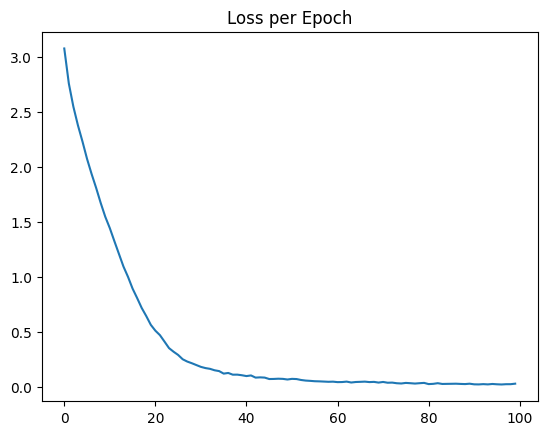

In [43]:
plt.title('Loss per Epoch')
plt.plot(epoch_losses)

It is observed that the loss elbowed at around 30 epochs, which might be enough to train the model on Sherlock text. Still, given the size of the GPT-2 base model, it should be able to infer text based on provided prompt after 100 epochs of training.

In [59]:
print(generate_text(new_model, 'It was a fine day in London when Sherlock', length=500))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


It was a fine day in London when Sherlock Holmes and I were seated at breakfast.
     "Dat," said I as I stood one morning, my mind turned from horror to excitement. "The Count has come home already; he is sulking upon account of his haste."

        My friend rose lazily from his armchair and patted me up -- glancing over the shoulder--"his face is red-purple; it seems rather queer that young man should dwell on such trivial matters instead!" He smiled and shook our hands. "I am glad to see him working hard for what he loves."

    We sat after supper by the fire during the night, watching each other's performances. Then suddenly waking, we saw Lestrade walking down Main Street with a wooden stick in his hand. Beside himself, he was cheering wildly against the clock. As always happens, this strange fellow had never seemed so sad or disinterested about anything. MOVED UP TO HIS EAST PENNY ATLANTA: All eyes were upon Dr Watson until four o'clock. In the instant he came out of the room c

A lot more coherent story is produced by the fine tuned model. It is observed that the story now contains more characters from the original Sherlock stories and is written a lot more in the style of Sir Arthur Conan Doyle. It does start to lose the context and hallucinate after a while, but its observed more closer to be to the style of the text in the corpus.

# Conclusion

By fine-tuning a pre-trained GPT-2 model on a curated dataset of Sherlock Holmes stories, we demonstrated that it is possible to create new narratives that capture the essence of Arthur Conan Doyle's writing style, including the intricate dialogue between Holmes and Watson, the atmospheric descriptions of London, and the engaging mystery plots that have captivated readers for generations.

The process involved preparing the text data, training the model with carefully selected hyperparameters, and generating new text based on prompts. The best-performing model configuration was identified through systematic hyperparameter tuning, which highlighted the importance of learning rate in such models.

## Limitations

While the project was able to create new story based on a prompt with notable flair of Sir Arthur Conan Doyle's writing, several limitations were also observed.

- The scope and diversity of the training dataset directly impacted the model's performance. 
- The model struggled to maintain narrative coherence over longer stretches of text. 
- The requirement for significant computational resources for model training and fine-tuning poses a limitation, especially for individuals or organizations with limited access to GPUs or cloud computing services.

## Future Directions

* **Enhanced Dataset Curation**: Including a broader range of texts from the same period or related genres could help the model learn a wider variety of narrative structures and linguistic styles, potentially improving coherence and reducing anachronisms.
* **Advanced Model Architectures**: Experimenting with newer or more complex transformer models, such as GPT-3 or domain-specific adaptations, might yield improvements in text generation quality and narrative coherence.
* **Interactive Feedback Loops**: Incorporating human feedback directly into the training process, through techniques like reinforcement learning from human feedback (RLHF), could help refine the model's outputs based on qualitative assessments.
* **Cross-Disciplinary Collaboration**: Partnering with experts in literature, history, and linguistics could enhance the dataset preparation and evaluation phases, ensuring that generated texts are both stylistically faithful and contextually appropriate.